# Модель лесного пожара

Лес состоит и пустой сетки $N \times N$. На протяжении каждого периода случайным образом
выбирается участок на сетке. Если участок пустой, то с вероятностью $p$ на нем вырастает
дерево, а с веростностью $1 - p$ не происходит ничего.

Если на участке растет дерево, то оно
с вероятностью $1 - p$ загорается и огонь распроcтраняется на все примыкающие участки с
деревьями.


In [75]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from scipy.stats import shapiro

In [76]:
class ForestField:
    def __init__(self, n=5, p = 0.6) -> None:
        self.n = n
        self.field = np.zeros((self.n, self.n), dtype=np.int32)
        self.p = p
        self.treesPreFire = []
        self.treesPostFire = []
         
    def step(self, burnAll = False):
        dirt = 0
        fire = -1
        tree = 1
        cell = (np.random.randint(0, self.n), np.random.randint(0, self.n))
        rand_val = np.random.rand()
        #forest growth
        if self.field[cell[0], cell[1]] == dirt and rand_val < self.p:
                self.field[cell[0], cell[1]] = 1
        self.treesPreFire.append(self.countTrees())
        #lightning strike
        if self.field[cell[0], cell[1]] == tree and rand_val >= self.p:
            self.field[cell[0], cell[1]] = -1
        #fire spread
        self.fireSpread(burnAll)
        #fire extinguish
        self.field[self.field == -1] = 0
        self.treesPostFire.append(self.countTrees())
        
    def fireSpread(self, burnAll = False):
        dx = [-1, 0, 1, 0, -1, -1, 1, 1]
        dy = [0, 1, 0, -1, -1, 1, 1, -1]
        old_field = None
        while old_field is None or (old_field != self.field).any():
            old_field = self.field.copy()
            for i in range(self.n):
                for j in range(self.n):
                    for k in range(len(dx)):
                        if not ( 0 <= i + dx[k] < self.n and 0 <= j + dy[k] < self.n):
                            continue
                        if self.field[i + dx[k]][j + dy[k]] == 0 or self.field[i][j] == 0:
                            continue
                        if self.field[i + dx[k]][j + dy[k]] == -1:
                            self.field[i][j] = -1
            if not burnAll:
                return
        
    def countTrees(self):
        return np.sum(self.field[self.field == 1])

Посмотрим на численность леса в течение продолжительного времени и исследуем распределение леса по его размеру

In [103]:
n = 10
p = 0.7
forest = ForestField(n=n, p=p)
time_steps = 10000

In [104]:
for _ in range(time_steps):
    forest.step(burnAll=True)

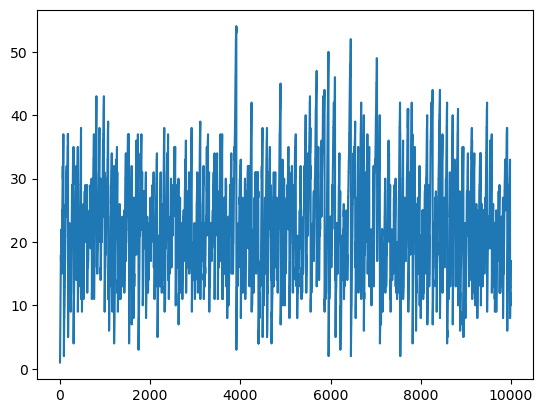

In [105]:
plt.plot(np.arange(len(forest.treesPreFire)), forest.treesPreFire)

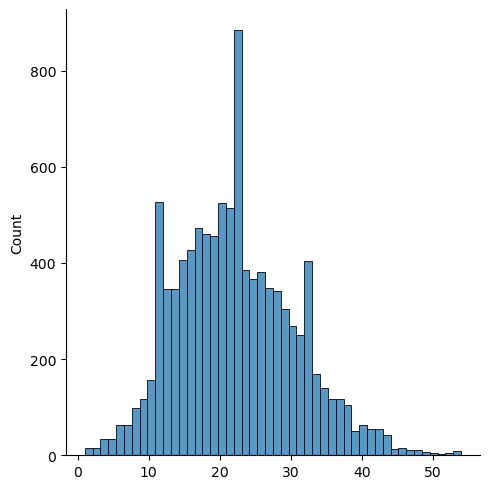

In [106]:
sns.displot(forest.treesPostFire)

In [107]:
stat, p = shapiro(forest.treesPostFire)
alpha = 0.05
if p > alpha:
    print('Распределение соответствует нормальному')
else:
    print('Распределение не похоже на нормальное')

Распределение не похоже на нормальное


c:\Users\roman\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


Согласно статистическому тесту полученное распределение не является нормальным. Однако, по его виду можно оценить теоретическое значение среднего размера леса.

In [108]:
mean_size = np.mean(forest.treesPostFire)
print('Средний размер леса: ', np.round(mean_size))

Средний размер леса:  22.0


Проверим зависимость среднего размера леса от вероятности вырастания дерева $p$. Для этого проведём серию экспериментов с различными значениями вероятности и построим экспериментальную зависимость

In [85]:
p_vals = []
mean_vals = []
exp_num = 50
for _ in range(exp_num):
    p = np.random.random()
    exp_forest = ForestField(n,p)
    for _ in range(time_steps):
        exp_forest.step(burnAll=True)
    p_vals.append(p)
    mean_vals.append(np.mean(exp_forest.treesPostFire))

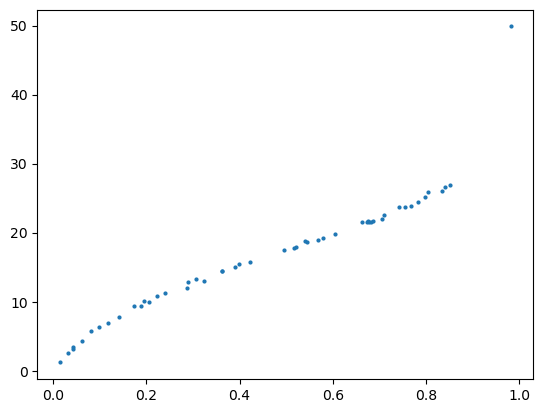

In [87]:
plt.scatter(p_vals, mean_vals, s=4)

В пределах от ~0.82 до 0.99 собралось мало данных, проведём доп. эксперименты

In [89]:
for _ in range(int(exp_num/10)):
    p = np.random.uniform(0.82, 1)
    exp_forest = ForestField(n,p)
    for _ in range(time_steps):
        exp_forest.step(burnAll=True)
    p_vals.append(p)
    mean_vals.append(np.mean(exp_forest.treesPostFire))

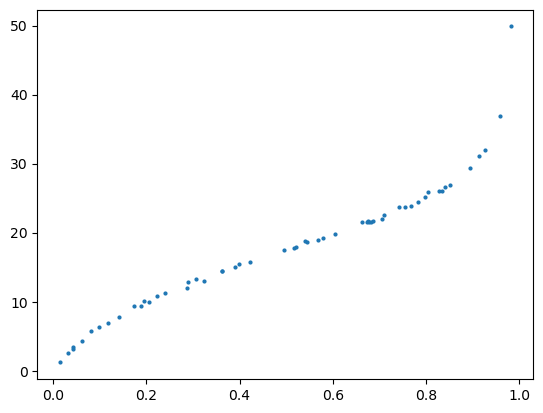

In [112]:
plt.scatter(p_vals, mean_vals, s=4)